In [1]:
import pyodbc
import sqlalchemy as sal
from sqlalchemy import create_engine

In [2]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plot
import seaborn as sns
import numpy as np
import folium
import matplotlib.pyplot as plt

In [3]:
with open('connection.txt', 'r') as f:
    DATABASE_URI = f.read()
engine = sal.create_engine(DATABASE_URI)
conn = engine.connect()

In [4]:
query_recent = "select * from get_prop_from_date('2020-08-01') where title ~ 'АПАРТАМЕНТ|МЕЗОНЕТ'"
recent = pd.read_sql_query(query_recent, engine)

In [5]:
pd.read_sql_query("select distinct measurement_day from holmes where title ~ 'АПАРТАМЕНТ|МЕЗОНЕТ'", engine)

,measurement_day
0,2020-05-29
1,2020-05-09
2,2020-03-21
3,2020-04-05
4,2020-07-18
5,2020-07-06
6,2020-06-05
7,2020-06-25
8,2020-08-01
9,2020-04-25


In [6]:
features = ['place', 'area', 'floor', 'views', 'title']
cat_features = [f for f in recent[features].columns if recent[f].dtypes == 'object']
num_features = [f for f in recent[features].columns if recent[f].dtypes == 'int64' or recent[f].dtypes == 'float64']
target = ['price']

In [8]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for col in cat_features:
    recent[col] = label_encoder.fit_transform(recent[col])

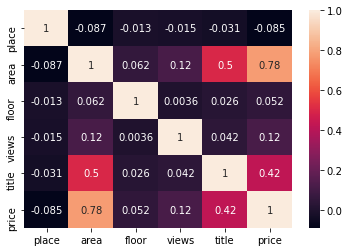

In [9]:
corrMatrix = recent[features + target].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [10]:
recent[features].head()

X = recent[features]
y = recent[target]

from sklearn.impute import SimpleImputer

# Imputation
cols = X.columns
my_imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(my_imputer.fit_transform(X))
X.columns = cols

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15831 entries, 0 to 15830
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   place   15831 non-null  float64
 1   area    15831 non-null  float64
 2   floor   15831 non-null  float64
 3   views   15831 non-null  float64
 4   title   15831 non-null  float64
dtypes: float64(5)
memory usage: 618.5 KB


In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor


# Function for comparing different approaches
def score_dataset_xgboost(X_train, X_valid, y_train, y_valid):
    model = XGBRegressor(n_estimators=10000, learning_rate=0.1)
    model.fit(X_train, y_train, 
             early_stopping_rounds=20, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

def score_dataset_linear(X_train, X_valid, y_train, y_valid):
    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

def score_dataset_rf(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)


print('XGBoost: {}'.format(score_dataset_xgboost(X_train, X_valid, y_train, y_valid)))
print('Linear: {}'.format(score_dataset_linear(X_train, X_valid, y_train, y_valid)))
print('RForest: {}'.format(score_dataset_rf(X_train, X_valid, y_train, y_valid)))

XGBoost: 20746.031534710983
Linear: 32154.389853606917


c:\users\shadow\venv\imoti_x64\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RForest: 21911.049535958624


## Explore additional features

In [28]:
details_query = """
select \
	unnest(string_to_array(trim(details->>'Особености:'), ',')) as details, \
    count(*) as count_
from holmes \
where measurement_day = (select max(measurement_day) from holmes) \
and title ~ 'АПАРТАМЕНТ|МЕЗОНЕТ'
group by 1
order by 2 desc
"""

details = pd.read_sql_query(details_query, engine)



In [29]:
details

,details,count_
0,Тухла,12961
1,Асансьор,10833
2,Контрол на достъпа,6763
3,С паркинг,4509
4,Саниран,4278
5,Интернет връзка,3554
6,В строеж,3535
7,С гараж,3305
8,Обзаведен,2767
9,Видео наблюдение,2675


In [37]:
floors = [ (fl, (recent.floor == fl).sum()) for fl in recent.floor.unique()]
floors.sort(key=lambda tup:tup[0])
floors

[(1.0, 2309),
 (2.0, 3094),
 (3.0, 2570),
 (4.0, 2115),
 (7.0, 839),
 (nan, 0),
 (5.0, 1863),
 (6.0, 1316),
 (8.0, 616),
 (9.0, 257),
 (10.0, 149),
 (11.0, 87),
 (12.0, 85),
 (13.0, 59),
 (14.0, 40),
 (15.0, 38),
 (16.0, 23),
 (17.0, 12),
 (18.0, 12),
 (19.0, 5),
 (20.0, 3),
 (21.0, 4),
 (24.0, 2)]